Load and setup data for training the datasets separated in two files from originai datasets:

`penguin-clean-train.csv` = datasets for training purpose, 70% from the original data

`penguin-clean-test.csv`  = datasets for testing purpose, 30% from the original data


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


from palmerpenguins import load_penguins


In [47]:

penguins_data = load_penguins()
penguins_data.head()

# ---- In real life, save your raw data before you clean data! ----

# Ensuring a hard copy of the data is made. Sometimes you will encounter errors with soft copying in Python. 
penguins_clean = penguins_data.copy()

# Drop rows with missing values
penguins_clean = penguins_clean.dropna()

# Remove the year and island columns
penguins_clean = penguins_clean.drop(columns=['year', 'island'])

# Make sex into a dummy variable
penguins_clean = pd.get_dummies(penguins_clean, columns=["sex"])

# Remove the male column and chinstrap column
penguins_clean = penguins_clean.drop(columns=['sex_male'])

# Turn species into a numeric code
penguins_clean['species'] = penguins_clean['species'].astype('category')

# Lets save a dictionary of the species codes
species_dict = dict(enumerate(penguins_clean['species'].cat.categories))
print(species_dict)

# Now we can replace the species column with the numeric codes
penguins_clean['species'] = penguins_clean['species'].cat.codes

{0: 'Adelie', 1: 'Chinstrap', 2: 'Gentoo'}


In [12]:

penguins_clean["species_code"].value_counts()


0    146
2    119
1     68
Name: species, dtype: int64

In [13]:

# Standardize the data
penguins_scaled = penguins_clean.copy()

# Choose which columns to scale
column_names = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]

# Create a scaler object
scaler = StandardScaler()

# Fit the scaler to the features and transform
penguins_scaled[column_names] = scaler.fit_transform(penguins_scaled[column_names])

penguins_scaled.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_female
0,0,-0.896042,0.780732,-1.426752,-0.568475,0
1,0,-0.822788,0.119584,-1.069474,-0.506286,1
2,0,-0.676280,0.424729,-0.426373,-1.190361,1
4,0,-1.335566,1.085877,-0.569284,-0.941606,1
5,0,-0.859415,1.747026,-0.783651,-0.692852,0


In [50]:

# Split the data into training and testing sets. A training set is used to train the model, and a testing set is used to evaluate the model.
penguin_train, penguin_test = train_test_split(penguins_scaled, test_size=0.3, random_state=100)

# Split the data into features and labels. The features are the columns used to make predictions, and the labels are the column we are trying to predict.
penguin_train_features = penguin_train.drop(columns=["species"])
penguin_train_labels = penguin_train["species"]

penguin_test_features = penguin_test.drop(columns=["species"])
penguin_test_labels = penguin_test["species"]

# Using Multilayer perceptron model, with one hidden layer.

# Create the model
mlp = MLPClassifier(hidden_layer_sizes=(10),
                    solver='sgd',
                    learning_rate_init=0.01,
                    max_iter=20,
                    random_state=100)

# Train the model
mlp.fit(penguin_train_features, penguin_train_labels)

# Make predictions
mlp_train_predictions = mlp.predict(penguin_train_features)
mlp_test_predictions = mlp.predict(penguin_test_features)



/Users/lfrance/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/004_REG/001_Teaching/AI_for_bioscience/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Training accuracy:  0.7939914163090128
Test accuracy:  0.8


Text(0, 0.5, 'Loss')

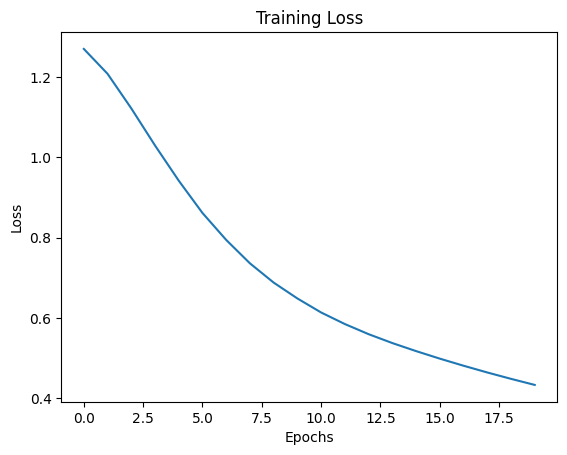

In [51]:

# Evaluate the model

# Training accuracy
mlp_train_accuracy = accuracy_score(penguin_train_labels, mlp_train_predictions)
print("Training accuracy: ", mlp_train_accuracy)

# Test accuracy
mlp_test_accuracy = accuracy_score(penguin_test_labels, mlp_test_predictions)
print("Test accuracy: ", mlp_test_accuracy)

# Plot the training and test accuracy. Training loss is the loss of the model on the training data. A low training loss means the model is a good fit for the training data. Epochs are the number of times the model is trained on the entire dataset.

plt.plot(mlp.loss_curve_)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")


Text(50.722222222222214, 0.5, 'Actual')

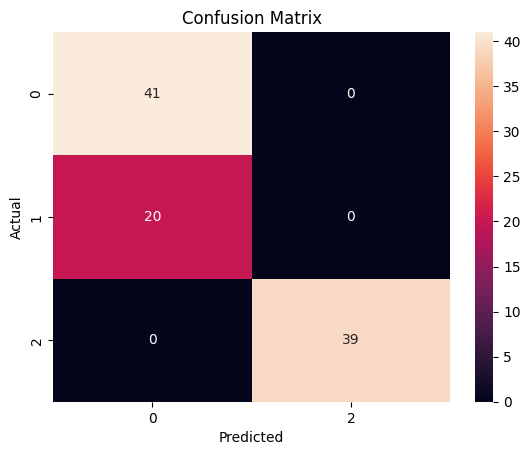

In [43]:

# Plot the confusion matrix. The confusion matrix shows how many times the model predicted each class correctly and incorrectly.

# Create the confusion matrix
mlp_confusion_matrix = pd.crosstab(penguin_test_labels, mlp_test_predictions, rownames=['Actual'], colnames=['Predicted'])


# Plot the confusion matrix
sns.heatmap(mlp_confusion_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")



In [61]:
# Finding out what the model is doing wrong


# Create a dataframe of the test data

penguin_test_df = penguin_test.copy()



# Add the predictions to the dataframe
penguin_test_df["prediction"] = mlp_test_predictions

# Add the correct/incorrect column

penguin_test_df["correct"] = penguin_test_df["species"] == penguin_test_df["prediction"]

# Change the species codes back to species names
penguin_test_df["species"] = penguin_test_df["species"].map(species_dict)
penguin_test_df["prediction"] = penguin_test_df["prediction"].map(species_dict)

# Show the incorrect predictions
penguin_test_df[penguin_test_df["correct"] == False]



Adelie    20
Name: prediction, dtype: int64

In [ ]:

# # Count the number of incorrect predictions for each species
penguin_test_df[penguin_test_df["correct"] == False]["species"].value_counts()

# # Count the false species predictions for each species
penguin_test_df[penguin_test_df["correct"] == False]["prediction"].value_counts()


# The model is having trouble with the Chinstrap species. The model is predicting the Adelie species when it is actually a Chinstrap species. This is because the Adelie species has the most data points, and the model is overfitting to the Adelie species.